TIME SERIES I ASSIGNMENT

AUTHORS: Sukanya Mukherjee, Yu Tinh, Jane 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import matplotlib.ticker as ticker
import numpy as np
import statsmodels.api as sm
#from urllib.request import urlopen
#from bs4 import BeautifulSoup
#from statsmodels.graphics.tsaplots import plot_acf
#from scipy.interpolate import UnivariateSpline
#from scipy import signal

In [2]:
#pip install --upgrade pandas
#print("pandas version: ",pd.__version__)
#print("numpy version: ",np.__version__)

## PART 1:  DATA EXPLORATION

### THE OIS RATE

The monetary policy variable is the overnight index swap rate for maturities that are 6 months away. The overnight interest swap is an over-the-counter interest rate derivative that is  used to hedge against interest rate risks. It is typically the difference between between the benchmark ECB overnight interest rate and the fixed rate decided by counterparties. 

The monetary policy variable considered in this analysis is the overnight interest swap at 6 months maturity. The overnight interest swap indexes itself to the key overnight rates set by the ECB. Thus, it is a suitable measure of the change in monetary policy. 

In [3]:
dataog = {}
for sheet in ['Press Release Window','Press Conference Window','Monetary Event Window']:
    dataog[sheet.split(' ')[1]] = pd.read_excel('Dataset_EA-MPD.xlsx',sheet_name=sheet)

#dataog is a dictionary of dataframes, and dataog["Event"] is the dataframe of "Monetary Event Window"
#the Monetary Event Window is the window from before the press release,13:25-13:35, till the window 
#after the press conference, 15:40-15:50. The latter is after the close of the stock markets. 

The general rule for the event window of the OIS is that the final change in the OIS rate is the net change in the rate
during the press release window and the press conference window. 

In [5]:
#ois6m_df = pd.DataFrame({"press_release":dataog["Release"]["OIS_6M"],"press_conference":dataog["Conference"]["OIS_6M"],"event":dataog["Event"]["OIS_6M"]})
ois6m_df["press_conference"].fillna(0,inplace=True)
ois6m_df["event_check"] = (ois6m_df["press_release"]+ois6m_df["press_conference"])-ois6m_df["event"] 

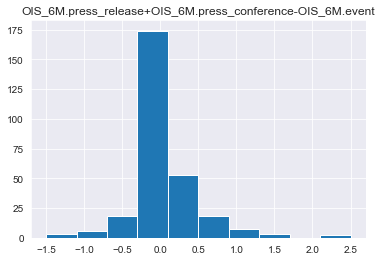

In [6]:
plt.hist(ois6m_df["event_check"])
plt.title("OIS_6M.press_release+OIS_6M.press_conference-OIS_6M.event")
plt.show()

The null hypothesis is that the OIS_6M change in the monetary event window is the sum of the change in the press release window and the press conference window, so,
$H_0 : \hat{\beta} = 0$

The test statistic = $\frac{\overline{x}}{std(x)}$

In [7]:
import scipy.stats as sc
tstat=ois6m_df["event_check"].mean()/ois6m_df["event_check"].std()
if sc.t.sf(tstat,ois6m_df.shape[0]-1)<0.01:
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

Accept null hypothesis


Thus, with 99% confidence it can be accepted that the total change in the monetary event window is the sum of the change in the press release window and the press conference window.

## PART 2: THE MONETARY POLICY MEASURE

The overnight interest swap rate is the exogenous shock in the model. The macroeconomic variables of interest are the Unemployment Rate, CPI(base year =2015), the Industrial Production Index (base year =2015) and the yields of the sovereign bond with 1 year maturity. A positive shock to the interest rate is a contractionary monetary policy. Therefore, it is expected that the unemployment rate will rise and the Industrial Production will decline in response to a hike in interest rate. The CPI should decline and any rise in interest rate should lower the bond price and thus, bond yields should increase.

The dataset is available from the date range as follows:

$\bullet$ the yield curve data is available from 2006-03 till 2022-12. 

$\bullet$ the ois data is available from 1999-01 to 2021-12

$\bullet$ the macro data is available from 1965-01 to 2022-10

Therefore, the intersection dataset is 2006-03 to 2021-12, that is, 10+(12*15)=190 monthly observations

During this period the major shocks to the Belgian economy have been the 2008 crash and the 2020 COVID crisis. 

In [9]:
df = pd.read_csv("Belgiumdf.csv")
df.shape

(190, 9)

In [10]:
df["log_cpi"]=np.log(df["cpi"]) #taking logarithms
df["log_indus"]=np.log(df["indus_index"])
df["lag_ix"]=189-df["Unnamed: 0"]
df.drop("Unnamed: 0",axis=1,inplace=True)
df=df.sort_values(by="lag_ix").reset_index(drop=True)# setting up a column of lags, recent observation is 2021-12
df["constant"]=1

In [11]:
df.head()

,Calendar_Month,unemp_rate,indus_index,cpi,OIS_6M_x,Event_Count,1Y_Bond_Yield,OIS_6M,log_cpi,log_indus,lag_ix,constant
0,2021-12,5.6,128.1,115.93,-0.275001,1,-0.00702,-0.275001,4.752987,4.852811,0,1
1,2021-11,5.8,125.4,115.95,-0.139999,0,-0.00779,0.000000,4.753159,4.831509,1,1
2,2021-10,6.0,132.2,114.33,-0.139999,1,-0.00664,-0.139999,4.739089,4.884316,2,1
3,2021-09,6.2,129.5,112.35,-0.030002,1,-0.00681,-0.030002,4.721619,4.863681,3,1
4,2021-08,6.3,131.1,112.41,-0.070000,0,-0.00685,0.000000,4.722153,4.875960,4,1


------------------------------------------Standardised Variables of Interest--------------------------------------------


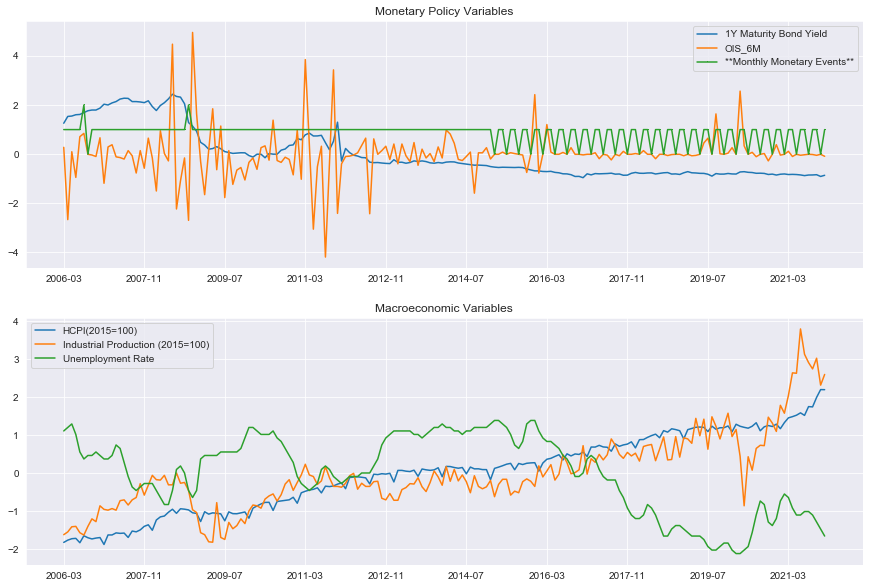

In [13]:
dfplot=df.sort_values(by="Calendar_Month")
fig,ax=plt.subplots(2,1,figsize=(15,10))
print("------------------------------------------Standardised Variables of Interest--------------------------------------------")
ax[0].plot(dfplot["Calendar_Month"],(dfplot["1Y_Bond_Yield"]-dfplot["1Y_Bond_Yield"].mean())/dfplot["1Y_Bond_Yield"].std(),label="1Y Maturity Bond Yield")
ax[0].plot(dfplot["Calendar_Month"],(dfplot["OIS_6M"]-dfplot["OIS_6M"].mean())/dfplot["OIS_6M"].std(),label="OIS_6M")
ax[0].plot(dfplot["Calendar_Month"],dfplot["Event_Count"],label="**Monthly Monetary Events**",marker=",")
ax[0].legend()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0].title.set_text("Monetary Policy Variables")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["cpi"]-dfplot["cpi"].mean())/dfplot["cpi"].std(),label="HCPI(2015=100)")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["indus_index"]-dfplot["indus_index"].mean())/dfplot["indus_index"].std(),label="Industrial Production (2015=100)")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["unemp_rate"]-dfplot["unemp_rate"].mean())/dfplot["unemp_rate"].std(),label="Unemployment Rate")
ax[1].legend()
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1].title.set_text("Macroeconomic Variables")
plt.show()

## PART 2: The Distributed Lag and Local Projection Models

### Class for the ARDL and Local Linear Projection Model

In [48]:
class lags_and_projections:
    '''
    a class to input the dataframe and lag values to generate a simple
    OLS estimated Impulse Response Function for Distributed Lag Model 
    and Linear Local Projection Model.
    '''
    def create_oisdf(self):
        '''
        the function that takes the exogenous variable and creates a dataframe of the
        specified q number of lags
        making a new dataframe allows better error catching and modification flexibility
        '''
        self.oisdf=pd.DataFrame({k:[np.nan]*self.df.shape[0] for k in self.lag_list}) #data frame with columns={lag=0,lag=1,...}
        self.oisdf["lag=0"]=self.df[self.exog_var]
        self.oisdf["Calendar_Month"]=self.df["Calendar_Month"]
        for q in range(self.x_lags-1):
            self.oisdf["lag="+str(q+1)]=list(self.df[(q+1):][self.exog_var])+[np.nan]*(q+1)
        self.oisdf.dropna(inplace=True)
        return self.oisdf
    
    def create_df(self):
        '''
        function that merges the dataframe of the lags of the exogenous variable with 
        the main dataframe of endogenous variable history
        '''
        oisdftemp=self.create_oisdf()
        self.reg_df=pd.merge(oisdftemp,self.df[["Calendar_Month",self.endog_var]+self.endog_lags],on="Calendar_Month",how="inner")
        self.reg_df["constant"]=1
        return self.reg_df
    
    def distributed_lag(self,give_betas=False,give_summary=False,give_data=False):
        '''
        function that performs simple OLS on the model as per specifications of the (AR) distributed 
        lag model,  it returns the estimated slope coefficients (give_betas=True), the OLS summary (give_summary=True) 
        and can also return the data used to fit the model (give_data=True) 
        '''
        reg_df=self.create_df()
        if give_data==True:
            return reg_df
        olsmodel=sm.OLS(reg_df[self.endog_var],reg_df[["constant"]+self.lag_list+self.endog_lags])
        self.olsmodel=olsmodel.fit()
        if self.n_lags==0:
            self.betas_dl=list(self.olsmodel.params[1:])
        if self.n_lags>0:
            self.betas_dl=list(self.olsmodel.params[1:-self.n_lags]) #last two coefficients are on lagged endogenous variables
        if give_betas==True:
            return self.betas_dl
        if give_summary==True:
            return self.olsmodel
        
    def local_projection(self,opt="Linear",give_betas=False,give_plot=False,give_data=False,give_summary=False):
        '''
        function that performs simple OLS on the model as per specifications of the (AR) linear local
        projection model,  it returns the estimated slope coefficients (give_betas=True), the OLS summary (give_summary=True) 
        and can also return the data used to fit the model (give_data=True) 
        '''
        reg_df=self.create_df()
        self.betas_lp=[]
        if give_data==True:
            return reg_df
        for h in range(self.x_lags):
            y=reg_df[[self.endog_var]].head(reg_df.shape[0]-h).reset_index(drop=True) #the future projection values
            x=reg_df[["constant","lag=0"]+self.endog_lags].loc[h:].reset_index(drop=True) #the past of the exog_var
            olsmodel=sm.OLS(y,x)
            self.olsmodel=olsmodel.fit()
            self.betas_lp.append(self.olsmodel.params[1])
        if give_betas==True:
            return list(self.betas_lp)
        if give_summary==True:
            return self.olsmodel.summary()
        
    def __init__(self,endog_var,n_lags=0,x_lags=24,df=df,exog_var="OIS_6M"):
        '''
        n_lags are the lags of the endogenous variable and x_lags are the lags of the exogenous variable
        '''
        self.x_lags=x_lags+1
        self.n_lags=n_lags
        self.exog_var,self.endog_var=exog_var,endog_var
        self.endog_lags=[]
        self.df=df
        if n_lags==0:
            self.df=df
        elif self.n_lags>0:
            #when the endogenous variable is autoregressive then the dataframe is altered at initialisation
            for i in range(self.n_lags):
                lx=self.endog_var+"-"+str(i+1) #creates column of the sort, eg, "unemp_rate-1", "unemp_rate-2" for lags={1,2}
                self.endog_lags.append(lx) #list of the ["unemp_rate-1", "unemp_rate-2"] used later when specifying model in OLS
                df[lx]=list(df[self.endog_var][i+1:])+[np.nan]*(i+1) #assigning values to df["unemp_rate-1"] is the unemp_rate column, 
                                                                     #shifted up by one value 
            self.df=df                                                   
        self.lag_list = ["lag="+str(q) for q in range(self.x_lags)] #column header for exogenous variable lags

In [52]:
def dual_plots(ser_lp,ser_dl,endog_var,lags=(0,24),bounds=False):
    endog_var_dict={"unemp_rate":"Unemployment Rate",
                   "log_cpi":"Log CPI Index(base=2015)",
                   "log_indus":"Log Industrial Activity Index(base=2015)",
                   "1Y_Bond_Yield":"1Y Maturity Bond Yield"}
    print("**************Impulse Response Functions for "+endog_var_dict[endog_var]+"**************")
    print("---- Endogenous Variable Lags = "+str(lags[0])+"  ----  "+"Exogenous Variable Lags = "+str(lags[1])+" ----")
    fig,ax=plt.subplots(1,2,figsize=(16,4))
    ax[0].plot(ser_dl)
    ax[0].title.set_text("**Distributed Lag Model**")
    ax[1].plot(ser_lp)
    ax[1].title.set_text("**Local Linear Projection Model**")
    plt.show()
    plt.close()

endog_var_x = ["unemp_rate","log_indus","log_cpi","1Y_Bond_Yield"]

### ARDL and Local Linear Projections Plots and Robustness Check

In [53]:
p,q=0,24 ### enter p,q for endogenous and exogenous lags

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


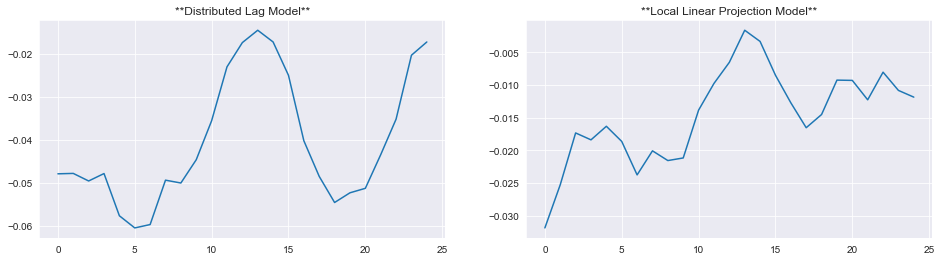

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


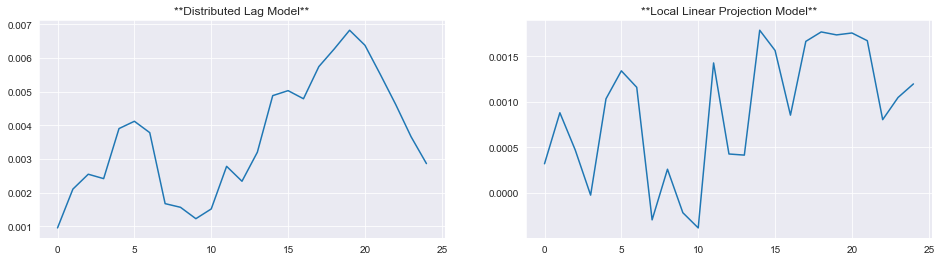

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


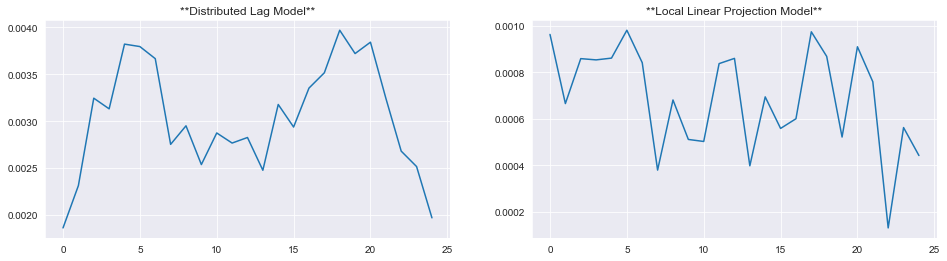

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


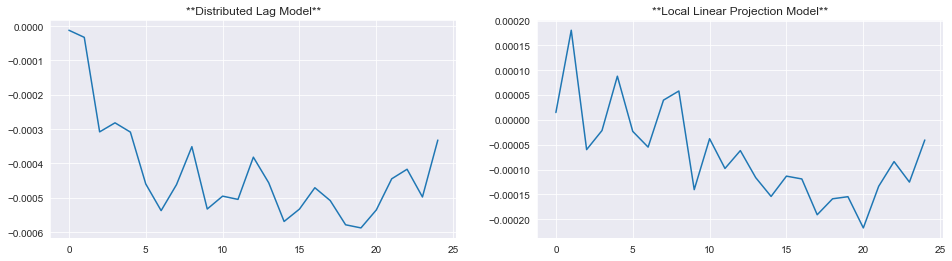

In [54]:
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var)

#### Robustness Check (endog_lag=1,exog_lag=24)

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


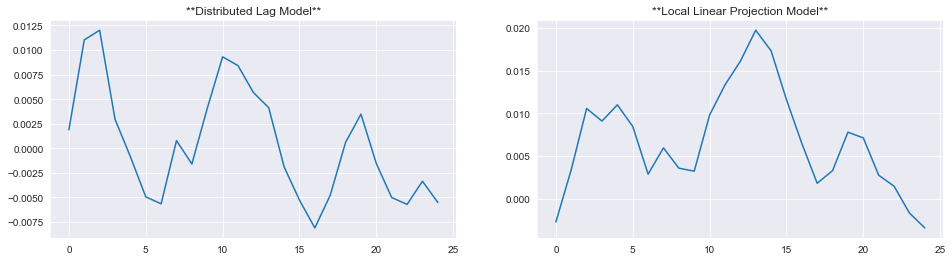

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


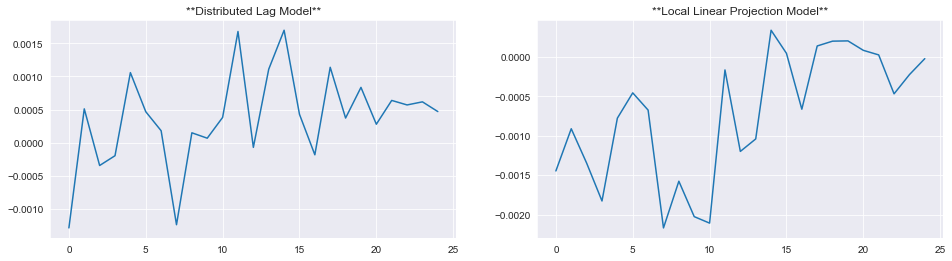

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


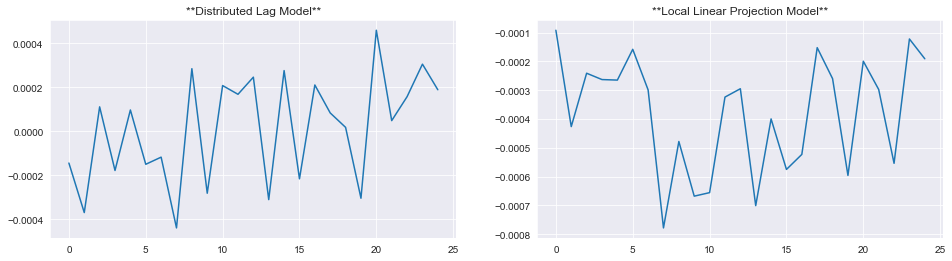

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


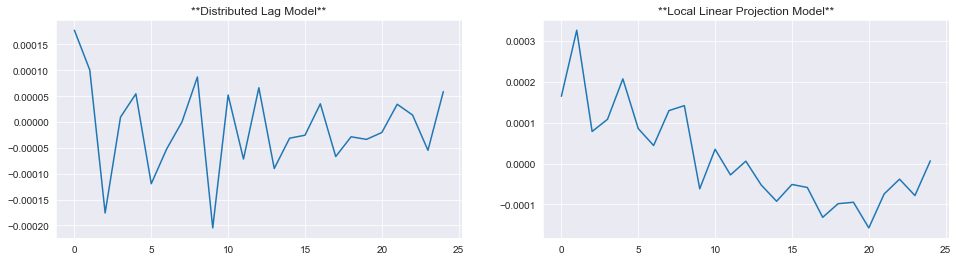

In [37]:
p=1
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

#### Robustness Check (endog_lag=2,exog_lag=24)

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


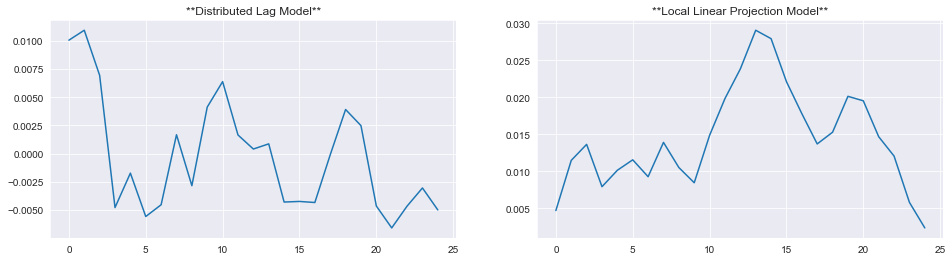

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


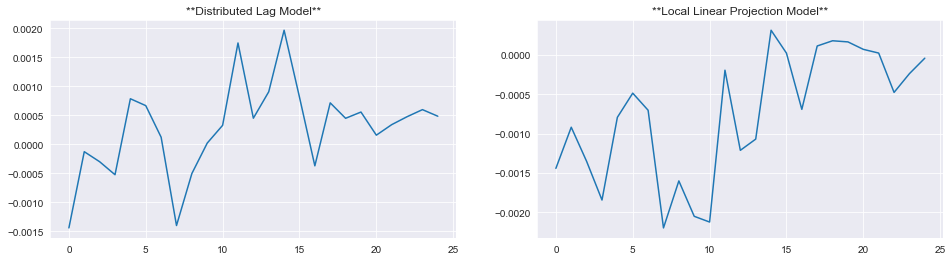

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


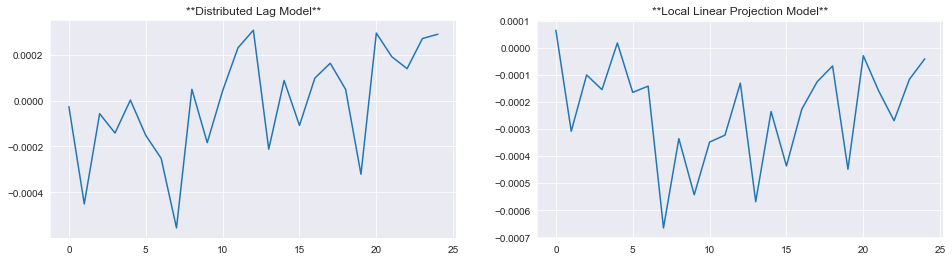

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


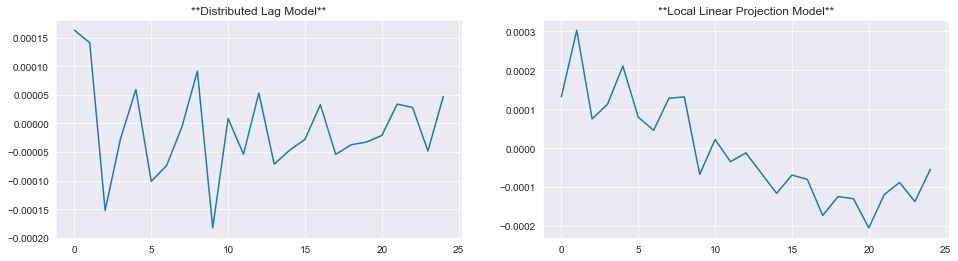

In [38]:
p=2
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 12 ----


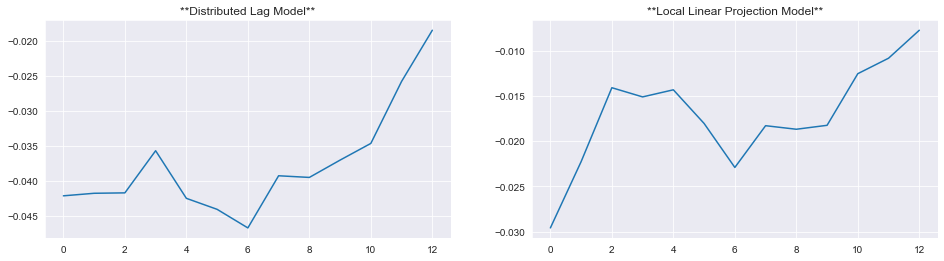

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 12 ----


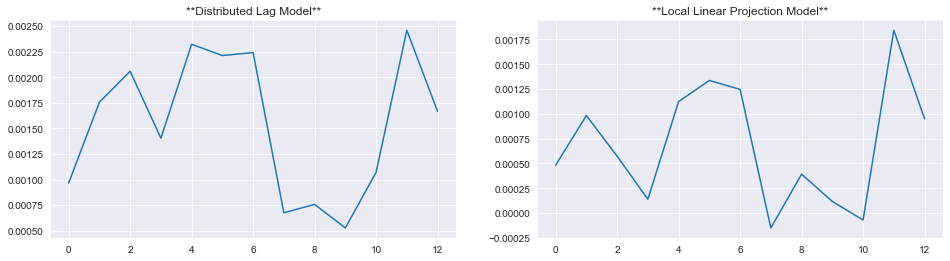

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 12 ----


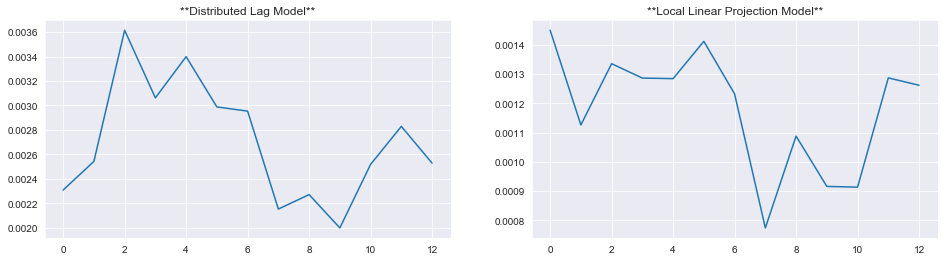

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 12 ----


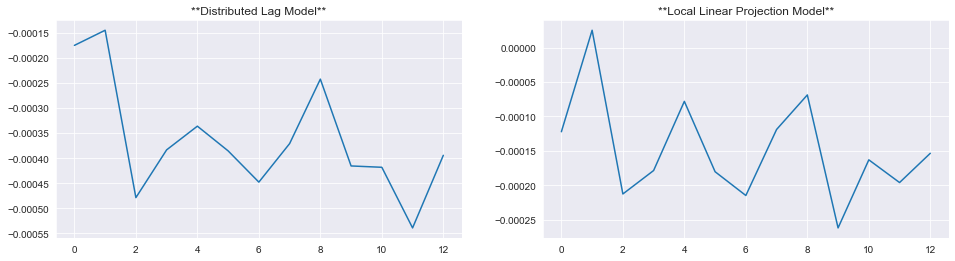

In [27]:
p,q=0,12
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 36 ----


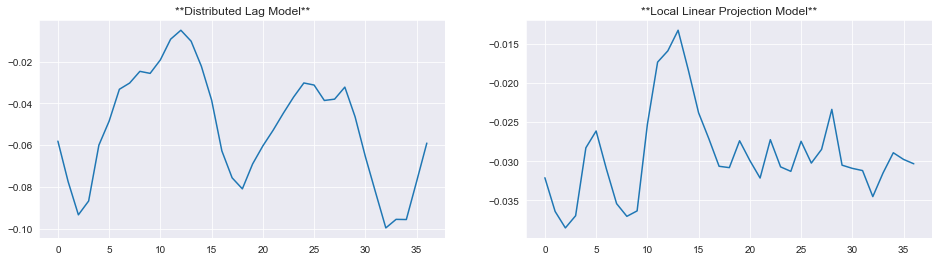

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 36 ----


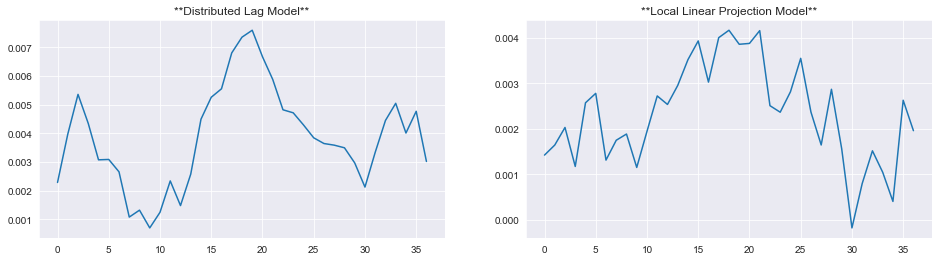

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 36 ----


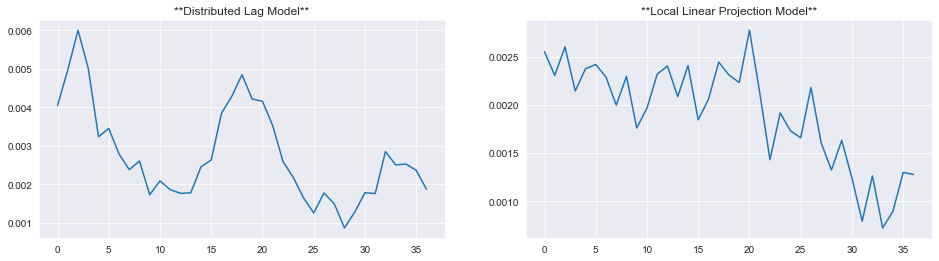

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 36 ----


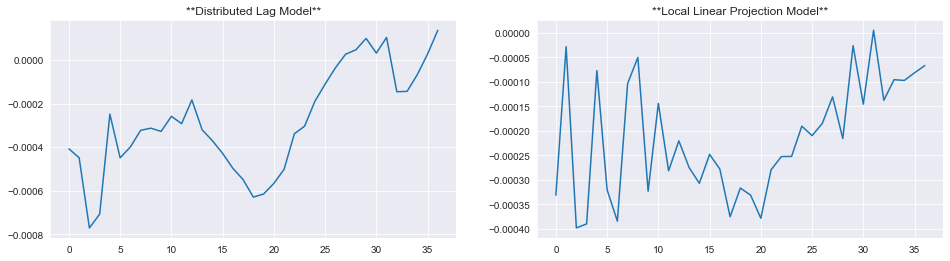

In [28]:
p,q=0,36
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

## APPENDIX: DATA PREPARATION

In [94]:
dataog['Event']['Calendar_Month'] = dataog['Event']['date'].apply(lambda x: str(x)[:7]) #removes the date and keeps only yyyy-mm
ois6m = dataog['Event'][['Calendar_Month','OIS_6M']].groupby('Calendar_Month').sum().reset_index() #the net monthly change in the OIS_6M
ois6m["Event_Count"]=dataog['Event'][['Calendar_Month','OIS_6M']].groupby('Calendar_Month').count().reset_index()["OIS_6M"] #the total number of events in OIS_6M in a  month

In [110]:
ois6m["yeardd"]=ois6m["Calendar_Month"].apply(lambda x: int(x.split("-")[0])*100+int(x.split("-")[1]))

In [96]:
ois6m[ois6m["yeardd"]>=200603]

,Calendar_Month,OIS_6M,Event_Count,yeardd
85,2006-03,0.950000,1,200603
86,2006-04,-8.900000,1,200604
87,2006-05,0.350000,1,200605
88,2006-06,-3.150000,1,200606
89,2006-07,2.400000,1,200607
...,...,...,...,...
241,2021-06,-0.129998,1,202106
242,2021-07,-0.070000,1,202107
243,2021-09,-0.030002,1,202109
244,2021-10,-0.139999,1,202110


Developing the country wide dataset: 

1. The consumer prices

2. The industrial production

3. The unemployment rate


In [101]:
date_list=[str(2006+yy)+"-0"+str(mm+1) for yy in range(16) for mm in range(9) ]+[str(2006+yy)+"-"+str(mm+10) for yy in range(16) for mm in range(3)]
date_list=sorted(date_list)[2:]

In [44]:
#preparing the unemployment rate and the industrial production index data

macrodf = pd.read_excel("data_prep.xlsx",sheet_name="new_data")
macrodf.dropna(inplace=True)
macrodf["Calendar_Month"]=date_list+[np.nan]*(macrodf.shape[0]-len(date_list))
macrodf.dropna(inplace=True)

In [125]:
#adding the harmonised consumer price index
macro_df = pd.merge(macrodf,pd.read_excel("data_prep.xlsx",sheet_name="inflation_data"),on="Calendar_Month",how="inner")

In [129]:
macro_df.dropna(inplace=True)

In [130]:
macro_df

,unemp_rate,indus_index,Calendar_Month,cpi
0,8.6,87.6,2006-03,84.16
1,8.7,88.3,2006-04,84.63
2,8.8,89.6,2006-05,84.93
3,8.5,89.7,2006-06,85.00
4,8,88.1,2006-07,84.09
...,...,...,...,...
185,6.3,131.1,2021-08,112.41
186,6.2,129.5,2021-09,112.35
187,6,132.2,2021-10,114.33
188,5.8,125.4,2021-11,115.95


In [111]:
oiszeros = pd.DataFrame({"Calendar_Month":date_list,
                        "OIS_6M":[np.nan]*len(date_list),
                        "Event_Count":[0]*len(date_list)
                        })
ois6m=ois6m[ois6m["yeardd"]>=200603]
ois6m=ois6m[ois6m["yeardd"]<202200]
ois6m.drop("yeardd",axis=1,inplace=True)

In [112]:
ois6m

,Calendar_Month,OIS_6M,Event_Count
85,2006-03,0.950000,1
86,2006-04,-8.900000,1
87,2006-05,0.350000,1
88,2006-06,-3.150000,1
89,2006-07,2.400000,1
...,...,...,...
241,2021-06,-0.129998,1
242,2021-07,-0.070000,1
243,2021-09,-0.030002,1
244,2021-10,-0.139999,1


In [113]:
ois6mdf=pd.merge(ois6m,oiszeros,on="Calendar_Month",how="outer").sort_values(by="Calendar_Month")
ois6mdf["OIS_6M_x"].fillna(0,inplace=True)
ois6mdf["Event_Count_x"].fillna(0,inplace=True)
ois6mdf["Event_Count"]=(ois6mdf["Event_Count_x"]+ois6mdf["Event_Count_y"]).astype(int)
ois6mdf["OIS_6M"]=ois6mdf["OIS_6M_x"]

In [114]:
ois6mdf

,Calendar_Month,OIS_6M_x,Event_Count_x,OIS_6M_y,Event_Count_y,Event_Count,OIS_6M
0,2006-03,0.950000,1.0,NaN,0,1,0.950000
1,2006-04,-8.900000,1.0,NaN,0,1,-8.900000
2,2006-05,0.350000,1.0,NaN,0,1,0.350000
3,2006-06,-3.150000,1.0,NaN,0,1,-3.150000
4,2006-07,2.400000,1.0,NaN,0,1,2.400000
...,...,...,...,...,...,...,...
188,2021-08,0.000000,0.0,NaN,0,0,0.000000
158,2021-09,-0.030002,1.0,NaN,0,1,-0.030002
159,2021-10,-0.139999,1.0,NaN,0,1,-0.139999
189,2021-11,0.000000,0.0,NaN,0,0,0.000000


In [ ]:
lag_cols=["lag_0"+str(i) for i in range(24)]
df[lag_cols]=0

In [38]:
X = [list(df["unemp_rate"])]*df.shape[0]

In [39]:
np.matrix(X).shape

(190, 190)

In [33]:
np.matrix(dl_mat).shape

(167, 190)

In [115]:
ois6mdf=ois6mdf[["Calendar_Month","OIS_6M","Event_Count"]]

In [131]:
#adding the ois6m data
macro_ois_df=pd.merge(macro_df,ois6mdf,on="Calendar_Month",how="inner")

In [98]:
yields_history=[]
#adding the 1year bond maturity
for ix in range(11):
    yieldURL = "https://www.marketwatch.com/investing/bond/tmbmkbe-01y/downloaddatapartial?partial=true&index="+str(ix)+"&countryCode=bx&iso=&startDate=01%2F03%2F2000%2000%3A00%3A00&endDate=12%2F23%2F2022%2000%3A00%3A00&frequency=P1M&downloadPartial=true&csvDownload=false&newDates=false"
    url = yieldURL
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")
    page_text = [x.split("\n\n\n") for x in soup.get_text().split("\n\n\n\n\n")[2:-1]][0]
    yields = [y.split("\n")[1]+","+y.split("\n")[-1] for y in page_text]
    yields_history = yields_history+yields

In [104]:
yields_history=yields_history[12:]

In [120]:
yielddf = {"Calendar_Month":[str(x.split(",")[0].split("/")[1])+"-"+str(x.split(",")[0].split("/")[0]) for x in yields_history],
          "1Y_Bond_Yield":[float(x.split(",")[1].replace("%",""))/100 for x in yields_history]
          }#bond yield/100

In [132]:
macro_ois_1y_df=pd.merge(macro_ois_df,pd.DataFrame(yielddf),on="Calendar_Month",how="inner")

In [134]:
belgium_df = macro_ois_1y_df[["Calendar_Month","unemp_rate","indus_index","cpi","OIS_6M","Event_Count","1Y_Bond_Yield"]]

In [135]:
belgium_df.to_csv("BelgiumDf.csv")

In [129]:
newdf=pd.merge(df,ois6mdf,on="Calendar_Month",how="inner")

In [130]:
newdf=newdf.rename(columns={"Event_Count_x":"Event_Count","OIS_6M_y":"OIS_6M"})

In [132]:
newdf.drop("Event_Count_y",axis=1,inplace=True)

In [135]:
newdf.to_csv("BelgiumDf.csv")